# Imports

In [1]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import pyreadr

from sklearn.calibration import CalibratedClassifierCV

In [2]:
from func import * 

# Preprocessing

In [3]:
transformer = Pipeline([
            ('features', FeatureUnion(n_jobs=1, transformer_list=[
                # Part 1
                ('boolean', Pipeline([
                    ('selector', TypeSelector('bool')),
                ])),  # booleans close
                
                ('numericals', Pipeline([
                    ('selector', TypeSelector(np.number)),
                    ('imputer',SimpleImputer()),
                    ('scaler', StandardScaler()),
                    
                ])),  # numericals close
                
                # Part 2
                ('categoricals', Pipeline([
                    ('selector', TypeSelector('category')),
                    ('labeler', StringIndexer()),
                    ('encoder', OneHotEncoder()),
                ]))  # categoricals close
            ])),  # features close
])  # pipeline close

estimators=[
            ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
            ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
            #('ridge',CalibratedClassifierCV(RidgeClassifier())),
            ('elasticnet',SGDClassifier(loss='log_loss', penalty='elasticnet')),
            ('random_forest',RandomForestClassifier(n_estimators=100, random_state=0)),
            #('svc', CalibratedClassifierCV(LinearSVC(dual=True, C=10))),
            ('deep_nn',MLPClassifier()),
            #('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto'))
]

_metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score),
         'accuracy':'accuracy','logloss':make_scorer(log_loss)}

estimator_names=[model[0] for model in estimators]

In [4]:
# Example tsv files
datasets = {
            'cnv': 'data/breast/CNV_processedDat.txt',
            'mrna': 'data/breast/mRNA_processedDat.txt',
            'prot': 'data/breast/PROT_processedDat.txt'
}
        
labels = 'data/breast/TCGA_BRCA_subtypes.txt'

# Individual Model Training + Performance

Here we train each model separately through cross validation and note performance. This is so that we can compare to ensemble results later.

In [15]:
x = {}
y = {}

train_x = {}
train_y = {}

val_x = {}
val_y = {}

eval_x = {}
eval_y = {}

for modality in datasets:
    x[modality], y[modality], train_x[modality], val_x[modality], eval_x[modality], train_y[modality], val_y[modality], eval_y[modality] = load_data(datasets[modality], labels)

## Without Cross-Validation

In [7]:
pipe_list = {}
pred = {}
pred_proba = {}

for modality in datasets:
    print('dataset: ' + modality)
    pipes = {}

    for model in estimators:
        pipe=Pipeline(steps=[('data_prep',transformer),model])
        pipe.fit(train_x[modality], train_y[modality])
        pipes[pipe.steps[1][0]]=pipe

    pipe_list[modality] = pipes

    pred[modality], pred_proba[modality] = prediction_results(pipe_list[modality], val_x[modality])
    

dataset: cnv


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


dataset: mrna
dataset: prot


### Initial Model Scoring

In [9]:
col_names = ['model', 'f1', 'accuracy']
results_list = {}

for modality in datasets:
    results = pd.DataFrame(columns=col_names)

    for name, pipe in pipe_list[modality].items():
        #print(roc_auc_score(val_target[modality], pred_proba[modality][name], average='weighted', multi_class='ovr'))
        #results = pd.concat([results, pd.DataFrame([[name, roc_auc_score(val_target[modality], pred_proba[modality][name], average='weighted', multi_class='ovr'), f1_score(val_target[modality], pred[modality][name], average='weighted'), accuracy_score(val_target[modality], pred[modality][name])]], columns=col_names)], ignore_index=True)
        results = pd.concat([results, pd.DataFrame([[name, f1_score(val_target[modality], pred[modality][name], average='weighted'), accuracy_score(val_target[modality], pred[modality][name])]], columns=col_names)], ignore_index=True)

    results_list[modality] = results

In [10]:
results_list['cnv']

,model,f1,accuracy
0,logistic,0.518301,0.54
1,lasso,0.539446,0.57
2,elasticnet,0.496433,0.51
3,random_forest,0.549116,0.61
4,deep_nn,0.487662,0.52


<AxesSubplot: >

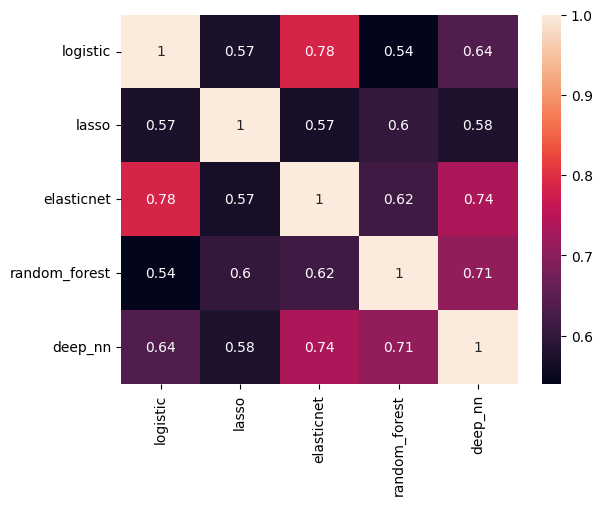

In [11]:
sns.heatmap(pred['cnv'].corr(), annot=True)

In [12]:
results_list['mrna']

,model,f1,accuracy
0,logistic,0.745929,0.74
1,lasso,0.790460,0.79
2,elasticnet,0.763650,0.76
3,random_forest,0.757397,0.78
4,deep_nn,0.801450,0.80


<AxesSubplot: >

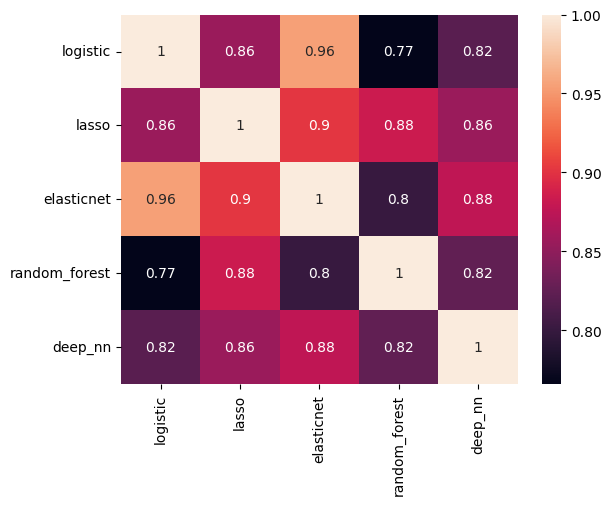

In [13]:
sns.heatmap(pred['mrna'].corr(), annot=True)

In [14]:
results_list['prot']

,model,f1,accuracy
0,logistic,0.444444,0.428571
1,lasso,0.572336,0.571429
2,elasticnet,0.513806,0.523810
3,random_forest,0.514099,0.571429
4,deep_nn,0.417316,0.380952


<AxesSubplot: >

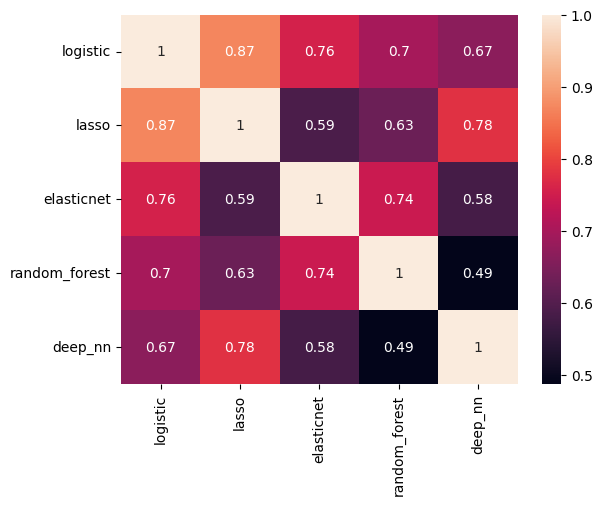

In [15]:
sns.heatmap(pred['prot'].corr(), annot=True)

## With Cross-Validation

In [16]:
col_names = ['model', 'accuracy']
cross_val_list = {}

for modality in datasets:
    cross_val = pd.DataFrame(columns=col_names)

    for name, pipe in pipes.items():
        scores = cross_val_score(pipe, x[modality], y[modality], cv=5)
        
        cross_val = pd.concat([cross_val, pd.DataFrame([[name, "%0.3f +/- %0.3f" % (scores.mean(), scores.std())]], columns=col_names)], ignore_index=True)

    cross_val_list[modality] = cross_val

KeyboardInterrupt: 

In [ ]:
cross_val_list['cnv']

,model,cross validation score
0,logistic,0.61 accuracy with a standard deviation of 0.00
1,lasso,0.65 accuracy with a standard deviation of 0.00
2,elasticnet,0.57 accuracy with a standard deviation of 0.00
3,random_forest,0.67 accuracy with a standard deviation of 0.00
4,deep_nn,0.60 accuracy with a standard deviation of 0.00


In [ ]:
cross_val_list['mrna']

,model,cross validation score
0,logistic,0.79 accuracy with a standard deviation of 0.00
1,lasso,0.85 accuracy with a standard deviation of 0.00
2,elasticnet,0.80 accuracy with a standard deviation of 0.00
3,random_forest,0.85 accuracy with a standard deviation of 0.00
4,deep_nn,0.82 accuracy with a standard deviation of 0.00


In [ ]:
cross_val_list['prot']

,model,cross validation score
0,logistic,0.62 accuracy with a standard deviation of 0.00
1,lasso,0.69 accuracy with a standard deviation of 0.00
2,elasticnet,0.64 accuracy with a standard deviation of 0.00
3,random_forest,0.58 accuracy with a standard deviation of 0.00
4,deep_nn,0.63 accuracy with a standard deviation of 0.00


# Modality Ensembles with Cross-Validation

In [5]:
def train_test(dataset, subtypes):    

    subtypes = pd.read_csv(subtypes, sep='\t', index_col=0)        

    df = pd.read_csv(dataset, sep='\t')
    df = df.transpose()

    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header

    data = pd.concat([df, subtypes], axis=1, join="inner")

    data.columns = data.columns.str.strip()

    target = data['PAM50']
    target = correct_dtypes(target)

    data = data.drop(columns=['PAM50'])
    data = data.astype('float')

    train_data, eval_data, train_target, eval_target = train_test_split(data, target, test_size=0.2, train_size=0.8)

    return data, target, train_data, eval_data, train_target, eval_target

In [6]:
data = {}
target = {}

train_data = {}
train_target = {}

eval_data = {}
eval_target = {}

for modality in datasets:
    data[modality], target[modality], train_data[modality], eval_data[modality], train_target[modality], eval_target[modality] = train_test(datasets[modality], labels)

## Weight Optimization

Here we apply cross validation to note the difference between weight optimization/equal weighted average in the voting classifier. We can use this to compare different techniques/parameters in order to maximize ensemble accuracy.

In [8]:
def cross_val_weights(estimators, esm_metrics, voting, data, target):
    cv = KFold(n_splits=5, random_state=None, shuffle=True)
    scores = list()

    for train_index, test_index in cv.split(data):
        
        # Spliting into intermediate training and test sets
        x_tr_va, x_test = data.iloc[train_index, :], data.iloc[test_index, :]
        y_tr_va, y_test = target.iloc[train_index], target.iloc[test_index]

        # Spliting training set into training and validation set
        x_train, x_val, y_train, y_val = train_test_split(x_tr_va, y_tr_va, test_size=0.25, random_state=1)

        print('Training base estimators...')
        # Training individual base estimators
        pipes = train_models(estimators, x_train, y_train, transformer)

        # Getting predictions from individual base estimators
        pred, pred_proba = prediction_results(pipes, x_val)

        print('Finding optimal weights...')

        # Finding optimal weights given predictions
        weights = find_weights(estimators, pipes, y_val, pred_proba)

        # Setting up ensemble voting classifier using calculated weights
        ens = Pipeline(steps=[('data_prep',transformer),(modality,VotingClassifier(estimators=estimators, voting = voting, weights = weights))])

        ens.fit(x_train, y_train)

        accuracy_score = ens.score(x_test, y_test)
        
        scores.append(accuracy_score)

        print('Training/Test Split Distribution: %s, Accuracy: %.3f' % (np.bincount(y_train), accuracy_score))
    
    print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))    

    # Creating metrics dataframe
    esm_metrics = pd.concat([esm_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores), np.std(scores))]], columns=col_names)], ignore_index=True)

    return esm_metrics

### Soft Voting:

In [9]:
from sklearn.base import clone

ensemble_pipes={}

col_names=['modality', 'accuracy']
esm_metrics = pd.DataFrame(columns=col_names)

for model in estimators:
    pipe=Pipeline(steps=[('data_prep',transformer),model])
    ensemble_pipes[pipe.steps[1][0]]=pipe

ensemble_estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in ensemble_pipes.values()] 

for modality in datasets:
    print('dataset: ' + modality)
    esm_metrics = cross_val_weights(ensemble_estimators, esm_metrics, 'soft', data[modality], target[modality])
    

dataset: cnv
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 59  34 135  72], Accuracy: 0.653
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 55  39 137  69], Accuracy: 0.610
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 56  35 135  74], Accuracy: 0.600
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 61  26 137  76], Accuracy: 0.680
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 57  34 139  70], Accuracy: 0.620


Cross-Validation accuracy: 0.633 +/- 0.030
dataset: mrna
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 58  37 125  78], Accuracy: 0.840
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 58  33 136  71], Accuracy: 0.810
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...
Training/Test Split Distribution: [ 56  35 138  69], Accuracy: 0.880
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 57  33 138  71], Accuracy: 0.869
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 59  32 135  73], Accuracy: 0.869


Cross-Validation accuracy: 0.853 +/- 0.025
dataset: prot
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [14 13 19 15], Accuracy: 0.810
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [15 10 17 19], Accuracy: 0.524
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [13  9 19 20], Accuracy: 0.619
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [17  7 18 20], Accuracy: 0.700
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [19 14 15 14], Accuracy: 0.5

In [12]:
col_names=['modality', 'accuracy']
esm_equal_metrics = pd.DataFrame(columns=col_names)

for modality in datasets:
    print('dataset: ' + modality)
    cv = KFold(n_splits=5, random_state=None, shuffle=True)
    ens = Pipeline(steps=[('data_prep',transformer),(modality,VotingClassifier(estimators=estimators, voting = 'soft'))])
    result = cross_val_score(ens, data[modality], target[modality], cv = cv)
    esm_equal_metrics = pd.concat([esm_equal_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(result.mean(), result.std())]], columns=col_names)], ignore_index=True)
    


dataset: cnv


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= p

dataset: mrna


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


dataset: prot


### Hard Voting

In [14]:
col_names=['modality', 'accuracy']
esm_metrics_hard = pd.DataFrame(columns=col_names)

for modality in datasets:
    print('dataset: ' + modality)
    esm_metrics_hard = cross_val_weights(ensemble_estimators, esm_metrics_hard, 'hard', data[modality], target[modality])

dataset: cnv
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...
Training/Test Split Distribution: [ 52  35 141  72], Accuracy: 0.634
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 60  36 131  73], Accuracy: 0.660
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 51  32 143  74], Accuracy: 0.630
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...
Training/Test Split Distribution: [ 60  32 131  77], Accuracy: 0.670
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 58  33 138  71], Accuracy: 0.580


Cross-Validation accuracy: 0.635 +/- 0.031
dataset: mrna
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 64  34 133  67], Accuracy: 0.870
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 51  31 144  72], Accuracy: 0.910
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 56  36 132  74], Accuracy: 0.880
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...
Training/Test Split Distribution: [ 60  40 131  68], Accuracy: 0.828
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 56  35 135  73], Accuracy: 0.818


Cross-Validation accuracy: 0.861 +/- 0.034
dataset: prot
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [14 10 18 19], Accuracy: 0.667
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [17 11 13 20], Accuracy: 0.667
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [14  9 16 22], Accuracy: 0.619
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [17  9 17 19], Accuracy: 0.550
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [14 10 19 19], Accuracy: 0.700


Cross-Validation accuracy: 0.640 +/- 0.052


In [16]:
col_names=['modality', 'accuracy']
esm_equal_metrics_hard = pd.DataFrame(columns=col_names)

for modality in datasets:
    print('dataset: ' + modality)
    cv = KFold(n_splits=5, random_state=None, shuffle=True)
    ens = Pipeline(steps=[('data_prep',transformer),(modality,VotingClassifier(estimators=estimators, voting = 'hard'))])
    result = cross_val_score(ens, data[modality], target[modality], cv = cv)
    esm_equal_metrics_hard = pd.concat([esm_equal_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(result.mean(), result.std())]], columns=col_names)], ignore_index=True)
    

dataset: cnv
dataset: mrna
dataset: prot


### Metrics

Optimized Weights w/ Soft Voting:

In [11]:
esm_metrics

,modality,accuracy
0,cnv,0.633 +/- 0.030
1,mrna,0.853 +/- 0.025
2,prot,0.630 +/- 0.114


Equal Weights w/ Soft Voting:

In [13]:
esm_equal_metrics

,modality,accuracy
0,cnv,0.629 +/- 0.031
1,mrna,0.859 +/- 0.018
2,prot,0.640 +/- 0.069


Optimized Weights w/ Hard Voting:

In [15]:
esm_metrics_hard

,modality,accuracy
0,cnv,0.635 +/- 0.031
1,mrna,0.861 +/- 0.034
2,prot,0.640 +/- 0.052


Equal Weights w/ Hard Voting:

In [17]:
esm_equal_metrics_hard

,modality,accuracy
0,cnv,0.629 +/- 0.031
1,mrna,0.859 +/- 0.018
2,prot,0.640 +/- 0.069
3,prot,0.690 +/- 0.069


# Modality Ensemble without Cross-Validation

### Learning Curves

KeyboardInterrupt: 

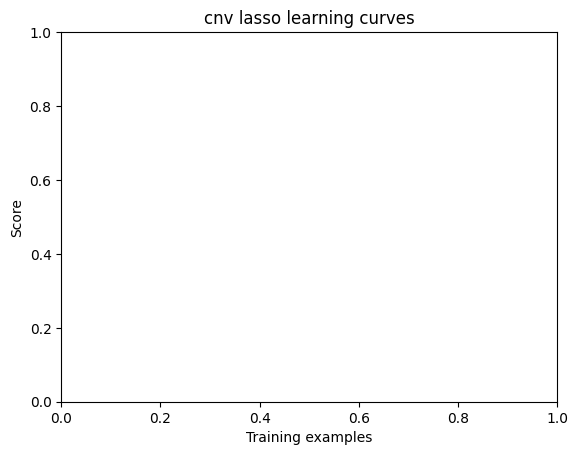

In [ ]:
to_plot=['random_forest','lasso','ridge']

for modality in datasets:
    t=transformer
    t.fit(train_data[modality])
    t=t.transform(train_data[modality])
    for name in pipe_list[modality].keys():
        if name in to_plot:
            g=func.plot_learning_curve(pipe_list[modality][name].named_steps[name],modality + ' ' + name+' learning curves',t,train_target[modality].values.ravel(),cv=KFold(4),n_jobs=4)

## Weight Optimization

In [18]:
weights = {}

for modality in datasets:
    weights[modality] = find_weights(estimators, pipe_list[modality], val_y[modality], pred_proba[modality])

TypeError: find_weights() missing 1 required positional argument: 'val_target'

In [ ]:
weights

{'cnv': array([0.18851376, 0.34982572, 0.06590574, 0.33935857, 0.05639621]),
 'mrna': array([0.07717722, 0.16062981, 0.18691691, 0.504642  , 0.07063405]),
 'prot': array([0.12495033, 0.30970444, 0.50057789, 0.04994828, 0.01481906])}

Equal Weights:

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

vote_equal = {}
col_names=['modality', 'f1', 'accuracy']
vote_equal_metrics = pd.DataFrame(columns=col_names)

for modality, df in datasets.items():
    estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipe_list[modality].values()] 

    # Same weights for each model
    vote_equal[modality]=Pipeline(steps=[('data_prep',transformer),(modality,VotingClassifier(estimators=estimators, voting = 'soft'))])

    vote_equal[modality].fit(train_data[modality], train_target[modality].values.ravel())

    predictions=vote_equal[modality].predict(eval_data[modality])

    vote_equal_metrics = pd.concat([vote_equal_metrics, pd.DataFrame([[modality, f1_score(eval_target[modality], predictions, average='weighted'), accuracy_score(eval_target[modality], predictions)]], columns=col_names)], ignore_index=True)

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


In [ ]:
vote_equal_metrics

,modality,f1,accuracy
0,cnv,0.570658,0.564356
1,mrna,0.827810,0.830000
2,prot,0.445578,0.476190


Optimized Weights (Differential Evolution)

In [ ]:
vote_weighted = {}
vote_weighted_metrics = pd.DataFrame(columns=col_names)

for modality, df in datasets.items():
    estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipe_list[modality].values()] 
    
    # Optimized weights (differential evolution)
    vote_weighted[modality]=Pipeline(steps=[('data_prep',transformer),(modality,VotingClassifier(estimators=estimators, voting = 'soft', weights=weights[modality]))])
    vote_weighted[modality].fit(train_data[modality],train_target[modality].values.ravel())
    predictions=vote_weighted[modality].predict(eval_data[modality])

    vote_weighted_metrics = pd.concat([vote_weighted_metrics, pd.DataFrame([[modality, f1_score(eval_target[modality], predictions, average='weighted'), accuracy_score(eval_target[modality], predictions)]], columns=col_names)], ignore_index=True)

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


In [ ]:
vote_weighted_metrics

,modality,f1,accuracy
0,cnv,0.614700,0.613861
1,mrna,0.860485,0.860000
2,prot,0.571429,0.571429


# Parameter Tuning

### Random Forest

In [ ]:
pipe_list['mrna']['random_forest'].named_steps['random_forest'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [ ]:
pipe_list[0]['random_forest'].set_params(**{'random_forest__max_depth': 8})
pipe_list[0]['random_forest'].set_params(**{'random_forest__max_leaf_nodes': 25})
pipe_list[0]['random_forest'].set_params(**{'random_forest__max_leaf_nodes': 200})

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer()),
                                                                                  ('scaler',
                                                                                   StandardScaler())])),
                                                                 ('categoricals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='category')),
                                                                                  ('labeler',
                                                                                   StringIndexer()),
                                                                                  ('encoder',
                                                                                   OneHotEncoder())]))]))])),
                ('random_forest',
                 RandomForestClassifier(max_depth=8, max_leaf_nodes=200))])

In [ ]:
param_grid={'max_depth':[3,8,13,18]}
func.tune_param('random_forest', pipe_list['mrna'], param_grid,chart='line')

param_grid={'max_leaf_nodes':[5,10,15,20,25]}
func.tune_param('random_forest',pipe_list['mrna'], param_grid,chart='line')

param_grid={'n_estimators':[10,50,100,150,200,500]}
func.tune_param('random_forest', pipe_list['mrna'], param_grid,chart='line')

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 268, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "

best score: nan
best params: {'random_forest__max_depth': 3}


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 268, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "

best score: nan
best params: {'random_forest__max_leaf_nodes': 5}


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 268, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "

best score: nan
best params: {'random_forest__n_estimators': 10}


# Feature Selection

### Feature Selection Using SequencialFeatureSelector

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

sfs1 = sfs(vote['mrna'], k_features=4, forward=False, verbose=1, scoring='neg_mean_squared_error')

sfs1 = sfs1.fit(data['mrna'], target['mrna'])

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 446, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 1193, in fit_transform
    results = self._parallel_func(X, y, fit_params, _fit_transform_one)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 1215, in _parallel_func
    return Parallel(n_jobs=self.n_jobs)(
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
    self.results = batch()
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/utils/fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 446, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/base.py", line 851, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/var/folders/bl/4vcbfl1n40sbx41l9qnkmm3h0000gn/T/ipykernel_13502/1010120027.py", line 7, in transform
    assert isinstance(X, pd.DataFrame)
AssertionError


### Feature Selection Using RFECV

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5)
min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=vote['cnv'],
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)

rfecv.fit(data['cnv'], target['cnv'])

# Plot pixel ranking
#plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

AssertionError: 

### Testing Model Combinations

In [ ]:
from itertools import combinations

def combine_models(final_estimators, pipes, data, target, eval_data, eval_target):

    combos=[]
    for L in range(2, len(final_estimators)+1):
        for subset in combinations(final_estimators, L):
            combos.append(list(subset))

    combo_names=[]
    auc=[]
    f1=[]
    logloss=[]
    accuracy=[]

    for combo in combos:
        estimators=[(name,clone(pipes[name].named_steps[name])) for name in combo] 
        vote=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators))])
        vote.fit(data,target)
        predictions=vote.predict(eval_data)

        #auc.append(roc_auc_score(eval_target,predictions))
        accuracy.append(accuracy_score(eval_target,predictions))
        #logloss.append(log_loss(eval_target,predictions))
        f1.append(f1_score(eval_target,predictions, average='weighted'))
        combo_names.append(str(list(combo)))
        
    score=pd.DataFrame()
    score['combo']=combo_names
    #score['auc']=auc
    score['f1']=f1
    score['accuracy']=accuracy

    return score

**CNV**

In [ ]:
score_cnv = combine_models(['logistic', 'lasso', 'random_forest', 'deep_nn'], pipe_list['cnv'], train_data['cnv'], train_target['cnv'],  eval_data['cnv'], eval_target['cnv'] )



# Creating Ensemble Mega-Model

In [ ]:
# TO DO: Fix this so that we consider validation data (is it the same data split just combined?)
def combine_data(datasets, subtypes):    

    subtypes = pd.read_csv(subtypes, sep='\t', index_col=0)        

    frames = {}
    
    for modality, df in datasets.items():
        frames[modality] = pd.read_csv(df, sep='\t')
        frames[modality] = frames[modality].transpose()
        new_header = frames[modality].iloc[0] #grab the first row for the header
        frames[modality] = frames[modality][1:] #take the data less the header row
        frames[modality].columns = new_header #set the header row as the df header

    df_list = list(frames.values())
    data = pd.concat(frames.values(), axis=1, join="inner")

    data = pd.concat([data, subtypes], axis=1, join="inner")

    target = data['PAM50']
    target = func.correct_dtypes(target)

    data = data.drop(columns=['PAM50'])
    data = data.astype('float')

    data, eval_data, target, eval_target = train_test_split(data,target,test_size=.20)

    return data, target, eval_data, eval_target

In [ ]:
ensemble_data, ensemble_target, ensemble_eval_data, ensemble_eval_target = combine_data(datasets, labels)

In [ ]:
modality_models=[(model.steps[1][0],clone(model.steps[1][1])) for model in vote_weighted.values()] 

# TO DO: CALCULATION OF WEIGHTS 
ensemble=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators=modality_models, voting = 'soft'))])
ensemble.fit(ensemble_data, ensemble_target.values.ravel())
predictions=ensemble.predict(ensemble_eval_data)

In [ ]:
metrics = pd.DataFrame([[f1_score(ensemble_eval_target, predictions, average='weighted'), accuracy_score(ensemble_eval_target, predictions)]], columns=['f1', 'accuracy'])

metrics

,f1,accuracy
0,0.777242,0.761905


### Saving Model

In [ ]:
from datetime import date
import pickle

today = date.today()

filename = date.today().strftime('%Y_%m_%d') + '_ensemble.sav'
pickle.dump(ensemble, open(filename, 'wb'))

# Comparing Models

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(ensemble_eval_data, ensemble_eval_target)
print(result)

0.9047619047619048
